# 23FA FoDS Project - Final Report
Jennie Li \
Nov. 30, 2023

## Libraries

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
! pip install autograd_minimize
from autograd_minimize import minimize

 ## Algorithm
 Using GD to estimate the proportion of targets in the library. Simulate the sequencing experiment with enrichment protocol, where for non-targeted items the observed count is 0.

### Cost function (for proportion estimation)

In [3]:
def cost(estimate, truth):
    c = np.square(np.subtract(truth,estimate)).mean()
    return c

### Gradient descent: to estimate target proportions based on biased observations

weight $\beta$ \\
$\beta \sim N(0, 1)$

count $x$ \\
$x \sim \text{Multinomial}(n, p), \text{where } p_i = \frac{\beta_i}{\sum{\beta}} $

In [4]:
# Gradient Descent - to estmate target proportions
def gd_estimate_proportion(beta_init,true_proportion, counts, enrichments, current_t, max_iterations=100, t_learning_rate = 0.00001, eval=False, plot=False):

	K = len(beta_init)

	# Calculate the log-likelihood and gradient
	def neg_log_likelihood_gradient(beta, x):
		gradient = x/beta - np.sum(x)/np.sum(beta) # attempt 4
		return - gradient

	# Lists to store cost during training
	cost_values = []

	beta = beta_init

	if eval == True:
		print("beta_initial: ", beta)
		print("Iteration \t gradient \t beta")

	for iteration in range(0, max_iterations):

		gradients = np.zeros(K)
		# revisit all graditents at each historical timepoints
		for t in range(0, current_t + 1):
			x_t = counts[t]
			enrich_list_t = enrichments[t]
			cur_ind = np.where(enrich_list_t)[0]
			gradient_t = np.zeros(K)
			gradient_t[cur_ind] = neg_log_likelihood_gradient(beta[cur_ind], x_t[cur_ind])
			gradients = gradients + gradient_t

		# Update beta using gradient descent
		beta = beta - t_learning_rate * gradients

		# Update beta using gradient descent
		# beta = np.maximum(beta - t_learning_rate * gradients, 0)  # Enforce non-negativity using ReLU

		c = cost(estimate=beta, truth=true_proportion)
		cost_values.append(c)

		if eval == True:
			if iteration < 10:
				print(iteration, gradients[:10],'\t', beta[:10])

	if plot:
		# Plotting Line Plot for Number of Iterations vs MSE
		plt.figure(figsize=(2, 2))  # Adjust the size as needed
		plt.plot(range(max_iterations),cost_values)
		plt.xlabel('Number of Iterations')
		plt.ylabel('Mean Squared Error')
		plt.title('Cost vs Iterations Analysis')
		plt.show()

	# torch_beta = torch.Tensor(beta)
	# softmax = torch.nn.Softmax(dim=0)
	# beta = softmax(torch_beta).numpy()
	# print(f"return beta: {beta}")
	return beta

In [5]:
## improve gd method with learning rate decay

def gd_estimate_proportion_lrdecay(beta_init, true_proportion, counts, enrichments, current_t, max_iterations=100, t_learning_rate = 0.00001, eval=False, plot=False):
    K = len(beta_init)

    def neg_log_likelihood_gradient(beta, x):
        gradient = x / beta - np.sum(x) / np.sum(beta)
        return -gradient

    cost_values = []
    beta = beta_init
    decay_factor = 0.99  # Adjust as needed

    if eval:
        print("beta_initial: ", beta)
        print("Iteration \t gradient \t beta")

    for iteration in range(max_iterations):
        gradients = np.zeros(K)

        for t in range(current_t + 1):
            x_t = counts[t]
            enrich_list_t = enrichments[t]
            cur_ind = np.where(enrich_list_t)[0]

            gradient_t = np.zeros(K)
            gradient_t[cur_ind] = neg_log_likelihood_gradient(beta[cur_ind], x_t[cur_ind])
            gradients = gradients + gradient_t

        t_learning_rate = t_learning_rate / (1 + iteration * decay_factor)
        # Update beta using gradient descent
        beta = beta - t_learning_rate * gradients
        # beta = np.maximum(beta - learning_rate * gradients, 0)

        c = cost(estimate=beta, truth=true_proportion)
        cost_values.append(c)

        if eval and iteration < 10:
            print(iteration, gradients[:10], '\t', beta[:10])

    if plot:
        plt.figure(figsize=(2, 2))
        plt.plot(range(max_iterations), cost_values)
        plt.xlabel('Number of Iterations')
        plt.ylabel('Mean Squared Error')
        plt.title('Cost vs Iterations Analysis')
        plt.show()

    return beta


In [6]:
def estimate_proportion(estimate_prop: np.ndarray,
                        counts: np.ndarray, enrichments: np.ndarray,
                        current_t: int, eval=False, plot=False):

    counts = counts[:current_t+1]           # counts at each tine points
    enrichments = enrichments[:current_t+1] # enriched targets at each time points
    enrich_list_t = enrichments[-1]         # enriched targets at current time t


    # Identify rows in enrichments where positions in enrich_list_t are True
    selected_rows = np.all(enrichments[:, enrich_list_t], axis=1)

    # Use these row indices to index array `counts` and sum those rows
    selected_counts = counts[selected_rows]

    # Sum vertically to get the cumulative count of each position given those rows
    # and set counts to zero for positions where enrich_list_t is False
    marginal_freq = np.sum(selected_counts * enrich_list_t, axis=0)

    # Calculate the sum of these individual sums
    total_sum = np.sum(marginal_freq)

    # Calculate new estimates of these positions
    position_estimate_prop_sum = np.sum(estimate_prop * enrich_list_t) # sum the estimated proportions of enriched targets at time t
    new_proportions = marginal_freq / total_sum * position_estimate_prop_sum

    # Update the values at these positions in list `estimate_prop`
    estimate_prop = [new_prop if enrich else old_prop for old_prop, new_prop, enrich in zip(estimate_prop, new_proportions, enrich_list_t)]

    return estimate_prop


Define Loss function based on estimate target proportion $p_s$:

$$
\text{Loss}(w) = \min_w \sum_{k=1}^{K} \left(\frac{N_t}{K} - \tilde{x}_t - w_s p_s n_t\right)^2
$$

In [7]:
# Define loss function
def gd_update_enrich_list(x_tilde, estimate_prop, K, N_t, n_t):
    torch_x_tilde = torch.Tensor(x_tilde) # x_tilde: cumulative count of a target
    torch_p = torch.Tensor(estimate_prop) # p: estimate proportion of a target

    def loss_function(w):
        # returns the degree to which one target should be enriched to reach balance
        # K, num of targets
        # N_t: cumulative sum of total read count at all previous time points
        # n_t: total read count at a time point
        # torch.softmax(w) # the values are dependent

        loss = torch.sum((N_t/K - torch_x_tilde - w * torch_p * n_t)**2)
        return loss

    # Use the minimize function to find the optimal w
    w_init = np.array([1/K] * K)
    w = minimize(loss_function, w_init, backend='torch')
    # print("Optimal w:", w.x)
    return w.x

### Simulate: update enrich list by minimizing loss between goal and predicted count


In [8]:
# Using estimated proportion, perform gradient descent on likelihood of enriching a target
def better_enrichment(K, N, n_timepoints, true_proportion, prop_init, method=None):

    # init
    enrichments = np.zeros(shape=(n_timepoints, K), dtype=bool)
    counts = np.zeros(shape=(n_timepoints, K), dtype=int)
    # control group for compairson
    control_counts = np.zeros(shape=(n_timepoints, K), dtype=int)
    estimate_prop = prop_init
    # beta = beta_init

    for t in range(0, n_timepoints):
        # print(f"at time of T{t}")
        if t == 0:
            # at T0, enrich all targets
            enrich_list = np.array([True] * K)
            # print(f"enrich list: {enrich_list}")

        else:
            cum_counts = np.sum(counts, axis=0) # cumulative counts

            # print(cum_counts)
            # print("estimated p: ", estimate_prop)
            w = gd_update_enrich_list(cum_counts, estimate_prop, K=K, N_t=N*n_timepoints, n_t=N)
            # print("w: ", w)
            # Set negative values to zero
            w[w < 0] = 0
            # Normalize w to create probabilities
            probs = w / sum(w)
            # print("probs:", probs)
            random = np.random.random(len(w))
            # print("random:", random)
            # Generate a random list of 0s and 1s based on the probabilities
            enrich_list = random <= probs
            # Check if all values in enrich_list are False
            if not any(enrich_list):
                # If all values are False, set the index of the maximum value in probs to True
                max_index = np.argmax(probs).item()
                enrich_list[max_index] = True

            # print("enrich_list: ", enrich_list)

        enrichments[t] = enrich_list # record enrich list at T0

        # Control: Draw counts of each target from a multinomial distribution
        control_obs = np.random.multinomial(N, true_proportion, size=1)[0]
        control_counts[t] = control_obs # in control case, record all observations

        # Enrich: Draw counts of enriched target
        enrich_true_proportion = true_proportion[enrich_list] / np.sum(true_proportion[enrich_list])
        enrich_obs = np.random.multinomial(N, enrich_true_proportion, size=1)[0]
        expanded_enrich_obs = np.zeros(len(enrich_list))
        expanded_enrich_obs[enrich_list] = enrich_obs

        counts[t] = expanded_enrich_obs # record counts at T

        # print("enrichments: ", enrichments)
        # print("counts: ", counts)

        if method == "gd":
            beta = gd_estimate_proportion(prop_init, true_proportion, counts, enrichments, current_t=t, max_iterations=1000, eval=False, plot=False)
            estimate_prop = beta / np.sum(beta) # reparameterization
        elif method == "gd_lrdecay":
            beta = gd_estimate_proportion_lrdecay(prop_init, true_proportion, counts, enrichments, current_t=t, max_iterations=1000, eval=False, plot=False)
            estimate_prop = beta / np.sum(beta) # reparameterization
        else:
            estimate_prop = estimate_proportion(estimate_prop, counts, enrichments, t)

        # print()

    # reparameterization
    # estimate_prop = beta / np.sum(beta)
    return estimate_prop, counts, control_counts

In [9]:
# Naive enrichment
def naive_enrichment(K, N, n_timepoints, true_proportion, prop_init, method=None):

    # init
    # Calculate the number of elements to drop
    num_to_drop = K * 2 // 3

    enrichments = np.zeros(shape=(n_timepoints, K))
    counts = np.zeros(shape=(n_timepoints, K))
    # control group for compairson
    control_counts = np.zeros(shape=(n_timepoints, K))

    for t in range(0, n_timepoints):
        # print(f"at time of T{t}")
        if t == 0:
            # at T0, enrich all targets
            enrich_list = np.array([True] * K)
            # print(f"enrich list: {enrich_list}")

        else:
            # Update enrich_list: Drop the 1/3 largest numbers
            cum_counts = np.sum(counts, axis=0) # cumulative counts
            indices_to_drop = np.argpartition(cum_counts, -num_to_drop)[-num_to_drop:] # Get the indices of the top 1/3 largest numbers
            for i in range(K):
                if i in indices_to_drop:
                    enrich_list[i] = False
                else:
                    enrich_list[i] = True
            # print("List after dropping top 1/3 large numbers:", enrich_list)

        enrichments[t] = enrich_list # record enrich list at T0

        # Control: Draw counts of each target from a multinomial distribution
        control_obs = np.random.multinomial(N, true_proportion, size=1)[0]
        control_counts[t] = control_obs # in control case, record all observations

        # Enrich: Draw counts of enriched target
        enrich_true_proportion = true_proportion[enrich_list] / np.sum(true_proportion[enrich_list])
        enrich_obs = np.random.multinomial(N, enrich_true_proportion, size=1)[0]
        expanded_enrich_obs = np.zeros(len(enrich_list))
        expanded_enrich_obs[enrich_list] = enrich_obs

        # obs[~enrich_list] = 0 # biased obs, Set elements in obs to 0 where enrich_list is False
        counts[t] = expanded_enrich_obs # record counts at T

        # print("enrichments: ", enrichments)
        # print("counts: ", counts)

    estimate_prop = None # Naive method does not use estimation
    return counts, control_counts

## Run different enrichment protocols

In [10]:
# Run the model
def one_run(seedid, method=None):
    rng = np.random.default_rng(seedid) # set seed

    # gd parameters
    t_learning_rate = 0.00001
    max_iterations = 10
    tolerance = 1e-6

    # parameters
    K = 10 # Number of target genes
    N = 100 # total count number per timepoint
    n_timepoints = 10

    # beta_init = np.array/([1/K] * K)
    prop_init = np.array([100/K/100] * K)
    true_beta = rng.normal(size=K) # sample weights
    true_exp_beta = np.exp(true_beta - np.max(true_beta))  # Apply softmax to normalize beta
    true_proportion = true_exp_beta / true_exp_beta.sum() # true proportion

    if method == "naive":
        counts, control_counts = naive_enrichment(K=K, N=N, n_timepoints=n_timepoints, true_proportion=true_proportion, prop_init=prop_init)
        return counts, control_counts

    else:
        estimate_prop, counts, control_counts = better_enrichment(K=K, N=N, n_timepoints=n_timepoints, true_proportion=true_proportion, prop_init=prop_init, method=method)

    return true_proportion, estimate_prop, counts, control_counts

# true_proportion, estimate_prop, counts, control_counts = one_run(42, method=None)
# true_proportion, estimate_prop, counts, control_counts = one_run(42, method="gd")
true_proportion, estimate_prop, counts, control_counts = one_run(42, method="gd_lrdecay")
# counts, control_counts = one_run(42, method="naive")

## Performance Evaluation

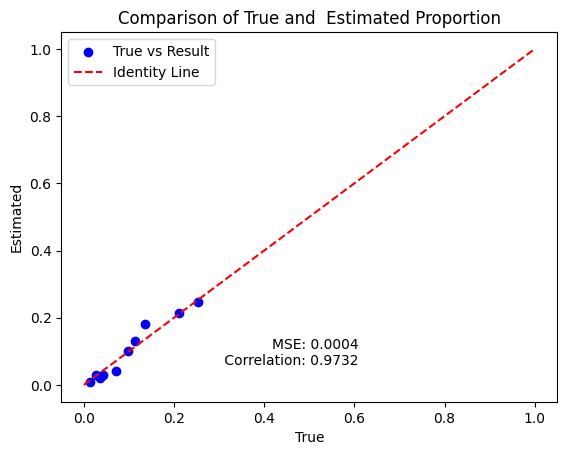

(0.0003903395500156981, 0.9732032632937039)

In [11]:
def eval_estimation_truth(result, truth, plot=False):
    # Calculate metrics
    mse = np.mean((truth - result)**2)
    correlation = np.corrcoef(truth, result)[0, 1]

    # Plotting
    if plot:
        fig, ax = plt.subplots()
        ax.scatter(truth, result, color='blue', label='True vs Result')
        ax.plot([0, 1], [0, 1], linestyle='--', color='red', label='Identity Line')

        ax.set_xlabel('True')
        ax.set_ylabel('Estimated')
        ax.set_title('Comparison of True and  Estimated Proportion')

        # Add text with metrics
        ax.text(0.6, 0.1, f'MSE: {mse:.4f}\n Correlation: {correlation:.4f}', fontsize=10, transform=ax.transAxes, ha='right')

        plt.legend()
        #plt.savefig(f"figures/Compare true and estimate")
        plt.show()

    return mse, correlation

eval_estimation_truth(estimate_prop, true_proportion, plot=True)

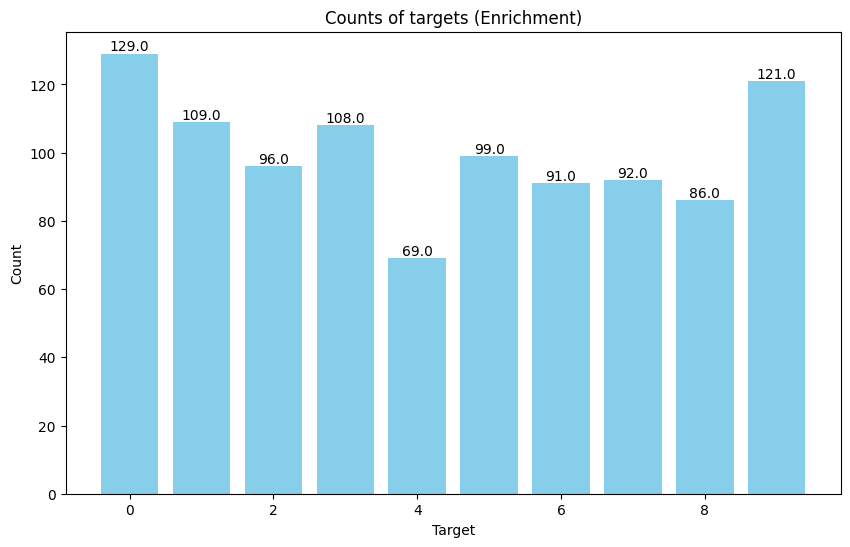

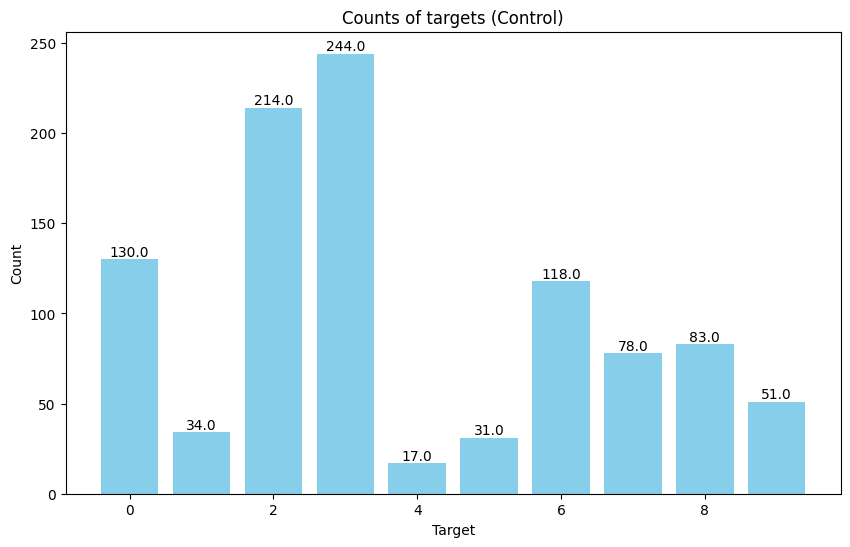

(0.845864, 73.57717037233765, 61.2, 227.0)

In [36]:
# Evaluate enrichment protocol

def evaluate_result(result, plot_title=None):
    # Calculate proportions
    total_count = np.sum(result)
    proportions = result / total_count

    # Gini Coefficient
    gini_coefficient = 1 - np.sum(proportions**2)

    # Coefficient of Variation
    mean_count = np.mean(result)
    standard_deviation = np.std(result)
    coefficient_of_variation = (standard_deviation / mean_count) * 100.

    # Mean Absolute Difference
    mean_abs_diff = np.mean(np.abs(result - np.mean(result)))

    # Value Range
    value_range = np.max(result) - np.min(result)

    # print(f"Standard Deviation: {std_dev}")
    # print(f"Mean Absolute Difference: {mean_abs_diff}")
    # print(f"Value Range: {value_range}")

    if plot_title:
        plt.figure(figsize=(10, 6))
        bars = plt.bar(range(len(result)), result, color='skyblue')

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

        plt.xlabel('Target')
        plt.ylabel('Count')
        plt.title(plot_title)
        #plt.savefig(f"figures/{plot_title}")
        plt.show()

    return gini_coefficient, coefficient_of_variation, mean_abs_diff, value_range

enrich_counts = np.sum(counts, axis=0)
evaluate_result(enrich_counts, plot_title='Counts of targets (Enrichment)')

control_res = np.sum(control_counts, axis=0)
evaluate_result(control_res, plot_title='Counts of targets (Control)')

## Multiple simulations

In [13]:
# # Number of simulations
# num_simulations = 500  # You can adjust this based on your needs

# # Storage for results across all runs
# ctl_mean_abs_diff = []
# ctl_gini_coefficient = []
# ctl_value_range = []
# ctl_coefficient_of_variation = []

# enrich_mean_abs_diff = []
# enrich_gini_coefficient = []
# enrich_value_range = []
# enrich_coefficient_of_variation = []

# estimate_truth_mse = []
# estimate_truth_corr = []

# # Run simulations
# for _ in range(num_simulations):
#     # Simulate data
#     true_proportion, estimate_prop, counts, control_counts = one_run(seedid=42)

#     # Evaluate estimation vs truth
#     mse, correlation = eval_estimation_truth(estimate_prop, true_proportion)
#     estimate_truth_mse.append(mse)
#     estimate_truth_corr.append(correlation)

#     # Evaluate enrichment protocol
#     enrich_counts = np.sum(counts, axis=0)
#     gini_coefficient, coefficient_of_variation, mean_abs_diff, value_range = evaluate_result(enrich_counts)

#     enrich_mean_abs_diff.append(mean_abs_diff)
#     enrich_gini_coefficient.append(gini_coefficient)
#     enrich_value_range.append(value_range)

#     # Evaluate control protocol
#     control_res = np.sum(control_counts, axis=0)
#     gini_coefficient, coefficient_of_variation, mean_abs_diff, value_range = evaluate_result(control_res)

#     # Store results for statistical summary
#     ctl_mean_abs_diff.append(mean_abs_diff)
#     ctl_gini_coefficient.append(gini_coefficient)
#     ctl_value_range.append(value_range)


average control's mean_abs_diff: 62.9096
average enrich's mean_abs_diff: 25.0640


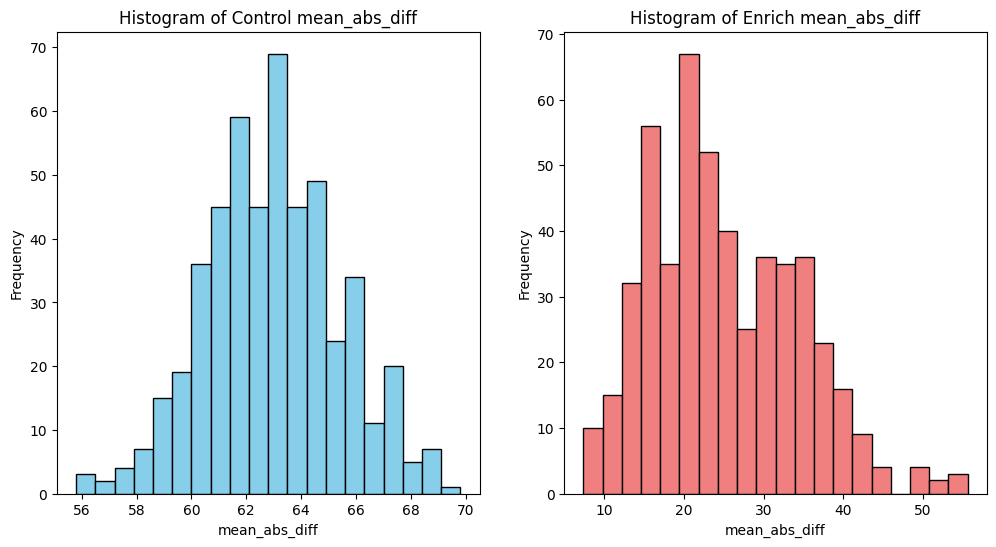

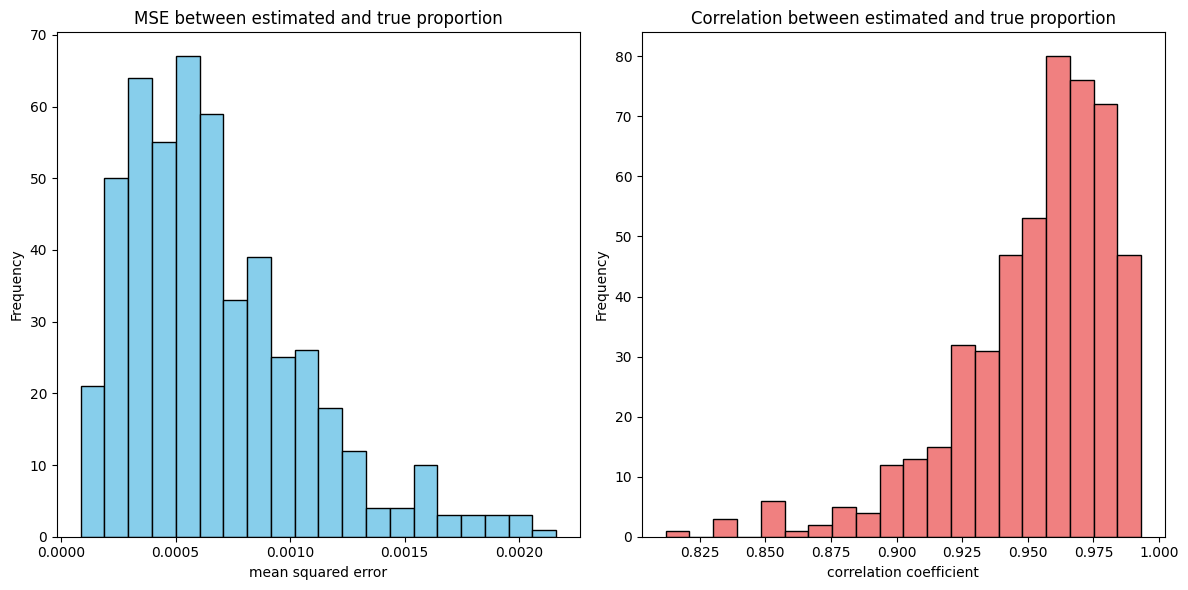

In [14]:

# from statistics import mean

# # Print or use the summary as needed
# print(f"average control's mean_abs_diff: {mean(ctl_mean_abs_diff):.4f}")
# print(f"average enrich's mean_abs_diff: {mean(enrich_mean_abs_diff):.4f}")


# # Plot histograms for enrichment results
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.hist(ctl_mean_abs_diff, bins=20, color='skyblue', edgecolor='black')
# plt.title('Histogram of Control mean_abs_diff')
# plt.xlabel('mean_abs_diff')
# plt.ylabel('Frequency')

# # Plot histograms for control results
# plt.subplot(1, 2, 2)
# plt.hist(enrich_mean_abs_diff, bins=20, color='lightcoral', edgecolor='black')
# plt.title('Histogram of Enrich mean_abs_diff')
# plt.xlabel('mean_abs_diff')
# plt.ylabel('Frequency')


# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.hist(estimate_truth_mse, bins=20, color='skyblue', edgecolor='black')
# plt.title('MSE between estimated and true proportion')
# plt.xlabel('mean squared error')
# plt.ylabel('Frequency')

# # Plot histograms for control results
# plt.subplot(1, 2, 2)
# plt.hist(estimate_truth_corr, bins=20, color='lightcoral', edgecolor='black')
# plt.title('Correlation between estimated and true proportion')
# plt.xlabel('correlation coefficient')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()

## Compare different algorithms

In [37]:
# Number of simulations
num_simulations = 100  # You can adjust this based on your needs

# Storage for results across all runs
algorithms = ['margin_prob', 'gd', 'gd_lrdecay', 'naive']

ctl_mean_abs_diff = {algo: [] for algo in algorithms}
ctl_gini_coefficient = {algo: [] for algo in algorithms}
ctl_value_range = {algo: [] for algo in algorithms}
ctl_coefficient_of_variation = {algo: [] for algo in algorithms}

enrich_mean_abs_diff = {algo: [] for algo in algorithms}
enrich_gini_coefficient = {algo: [] for algo in algorithms}
enrich_value_range = {algo: [] for algo in algorithms}
enrich_coefficient_of_variation = {algo: [] for algo in algorithms}

estimate_truth_mse = {algo: [] for algo in algorithms}
estimate_truth_corr = {algo: [] for algo in algorithms}

# Run simulations
for _ in range(num_simulations):
    for algo in algorithms:
        # Simulate data
        if algo == 'margin_prob':
            true_proportion, estimate_prop, counts, control_counts = one_run(seedid=42)
        elif algo == 'gd':
            true_proportion, estimate_prop, counts, control_counts = one_run(seedid=42, method="gd")
        elif algo == 'gd_lrdecay':
            true_proportion, estimate_prop, counts, control_counts = one_run(seedid=42, method="gd_lrdecay")
        elif algo == 'naive':
            counts, control_counts = one_run(seedid=42, method="naive")
        else:
            raise ValueError(f"Unknown algorithm: {algo}")

        if algo != "naive":
            # Evaluate estimation vs truth
            mse, correlation = eval_estimation_truth(estimate_prop, true_proportion)
            estimate_truth_mse[algo].append(mse)
            estimate_truth_corr[algo].append(correlation)

        # Evaluate enrichment protocol
        enrich_counts = np.sum(counts, axis=0)
        gini_coefficient, coefficient_of_variation, mean_abs_diff, value_range = evaluate_result(enrich_counts)

        enrich_mean_abs_diff[algo].append(mean_abs_diff)
        enrich_gini_coefficient[algo].append(gini_coefficient)
        enrich_value_range[algo].append(value_range)
        enrich_coefficient_of_variation[algo].append(coefficient_of_variation)

        # Evaluate control protocol
        control_res = np.sum(control_counts, axis=0)
        gini_coefficient, coefficient_of_variation, mean_abs_diff, value_range = evaluate_result(control_res)

        # Store results for statistical summary
        ctl_mean_abs_diff[algo].append(mean_abs_diff)
        ctl_gini_coefficient[algo].append(gini_coefficient)
        ctl_value_range[algo].append(value_range)
        ctl_coefficient_of_variation[algo].append(coefficient_of_variation)


<ipython-input-8-baf10ba75690>:29: RuntimeWarning: invalid value encountered in divide
  probs = w / sum(w)
<ipython-input-8-baf10ba75690>:29: RuntimeWarning: invalid value encountered in divide
  probs = w / sum(w)
<ipython-input-8-baf10ba75690>:29: RuntimeWarning: invalid value encountered in divide
  probs = w / sum(w)
<ipython-input-8-baf10ba75690>:29: RuntimeWarning: invalid value encountered in divide
  probs = w / sum(w)
<ipython-input-8-baf10ba75690>:29: RuntimeWarning: invalid value encountered in divide
  probs = w / sum(w)
<ipython-input-8-baf10ba75690>:29: RuntimeWarning: invalid value encountered in divide
  probs = w / sum(w)
<ipython-input-8-baf10ba75690>:29: RuntimeWarning: invalid value encountered in divide
  probs = w / sum(w)
<ipython-input-8-baf10ba75690>:29: RuntimeWarning: invalid value encountered in divide
  probs = w / sum(w)
<ipython-input-8-baf10ba75690>:29: RuntimeWarning: invalid value encountered in divide
  probs = w / sum(w)
<ipython-input-8-baf10ba7569

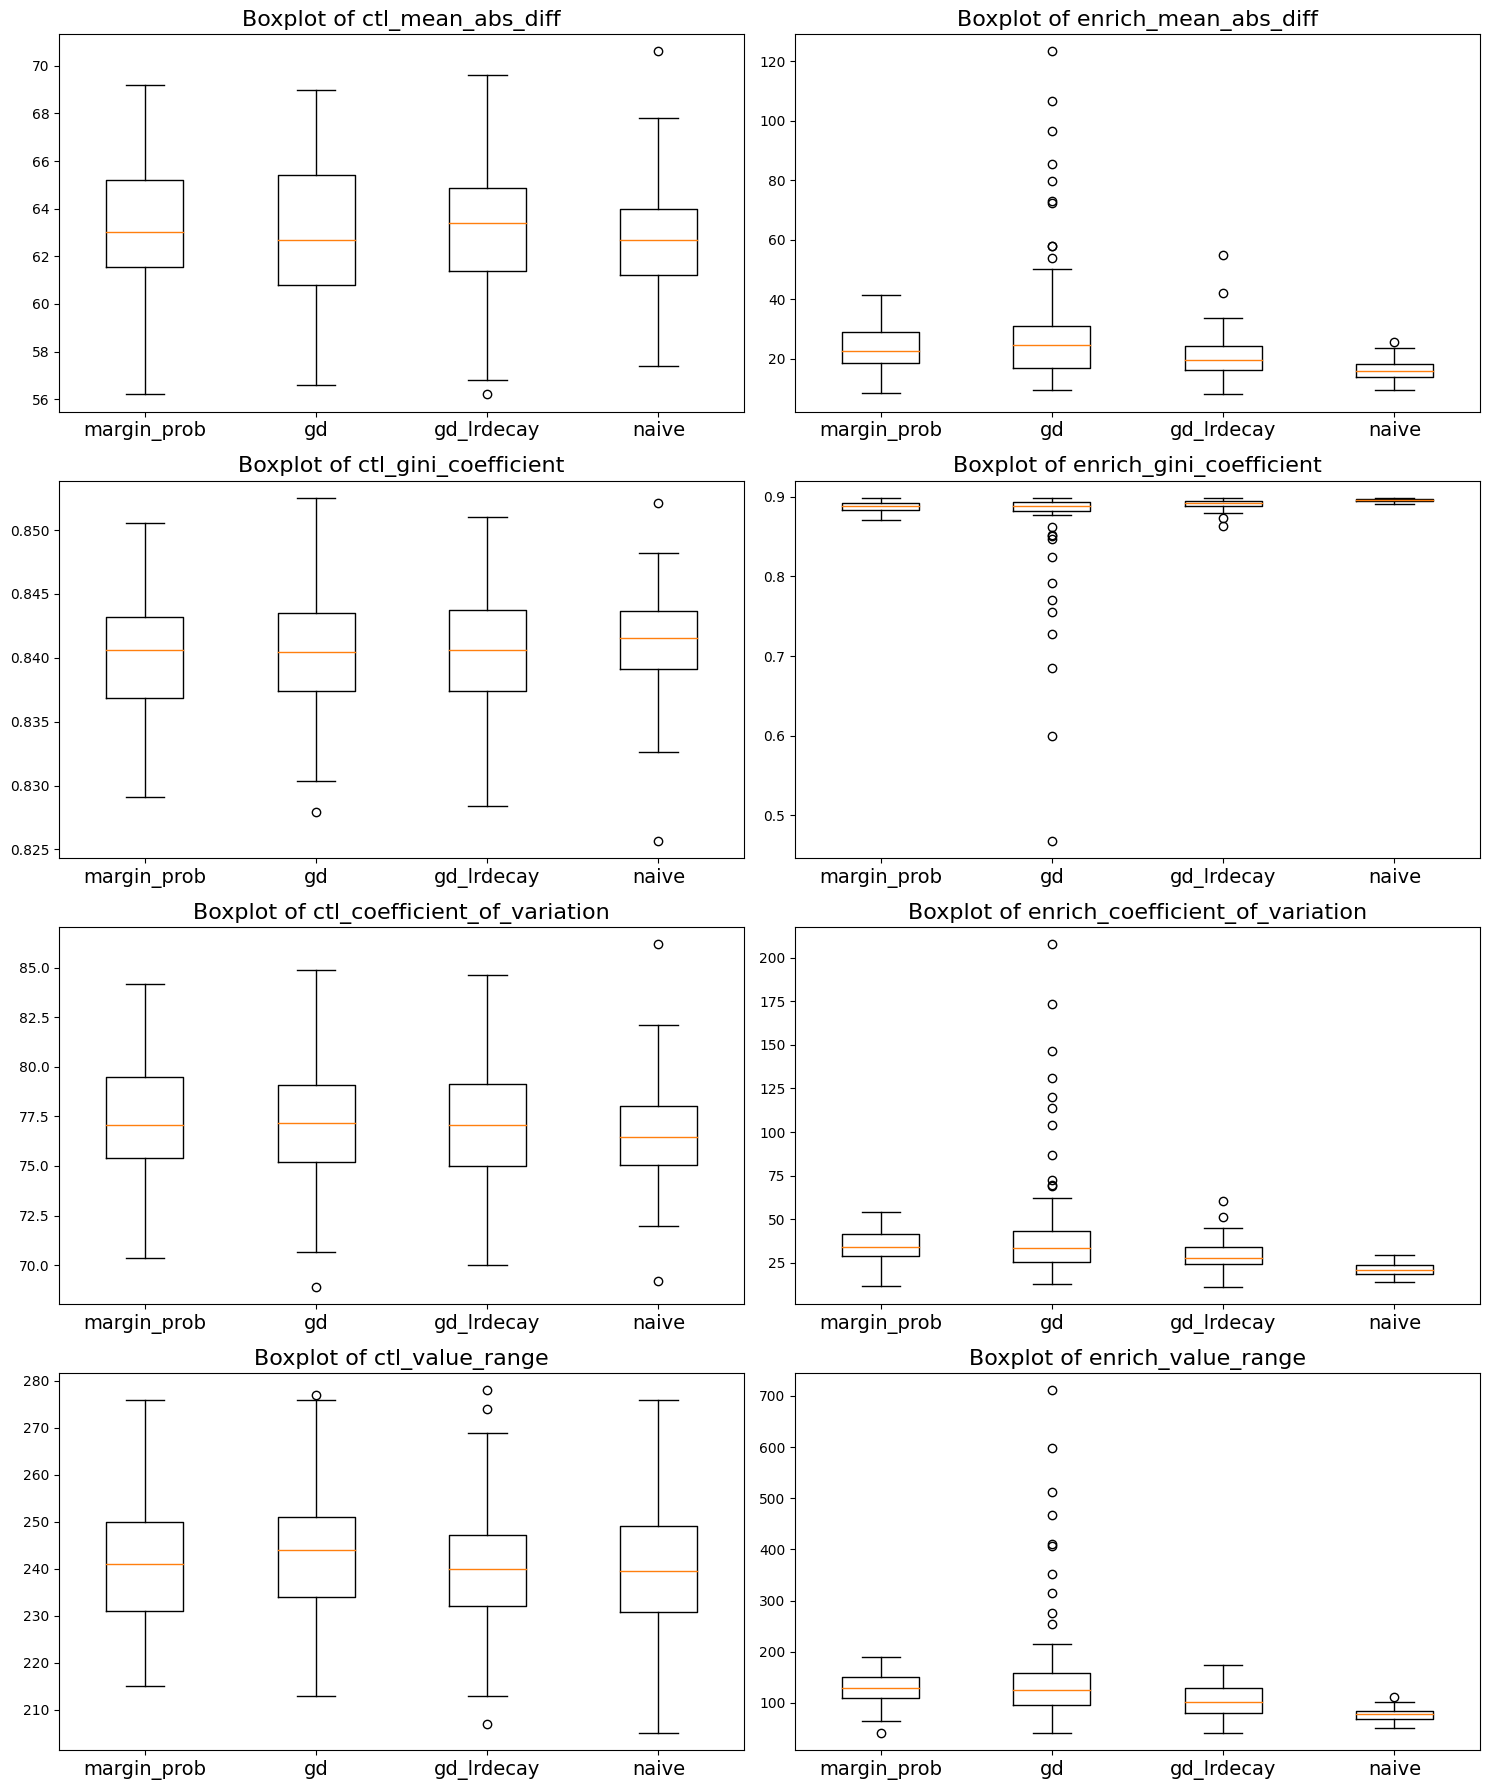

In [38]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 18))

for i, metric in enumerate(['ctl_mean_abs_diff', 'enrich_mean_abs_diff',
                            'ctl_gini_coefficient', 'enrich_gini_coefficient',
                            'ctl_coefficient_of_variation', 'enrich_coefficient_of_variation',
                            'ctl_value_range', 'enrich_value_range']):
    row, col = divmod(i, 2)
    ax = axes[row, col]

    data = {algo: eval(metric)[algo] for algo in algorithms}
    ax.boxplot(data.values(), labels=data.keys())
    ax.set_title(f'Boxplot of {metric}', fontsize=16)
    ax.tick_params(axis='x', labelsize=14)  # Set the x-axis tick label fontsize


plt.tight_layout()
plt.show()

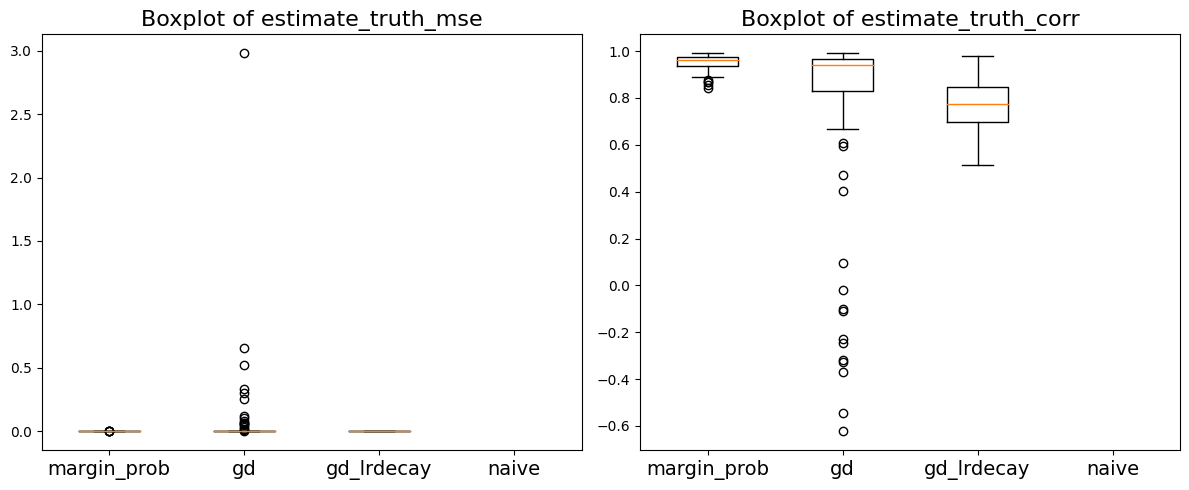

In [39]:
# Create boxplots to compare algorithms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for i, metric in enumerate(['estimate_truth_mse', 'estimate_truth_corr']):
    ax = axes[i]
    data = {algo: eval(metric)[algo] for algo in algorithms}
    ax.boxplot(data.values(), labels=data.keys())
    ax.set_title(f'Boxplot of {metric}', fontsize=16)
    ax.tick_params(axis='x', labelsize=14)  # Set the x-axis tick label fontsize

plt.tight_layout()
plt.show()

## Notes

In [61]:
# Example data
K = 3  # Replace with the actual size of your arrays
estimate_prop = [0.33, 0.33, 0.33]  # Replace with your actual prop list
estimate_prop = [0.11666666666666668, 0.08333333333333334, 0.8] # [0.1, 0.1, 0.8]
counts = np.array([[1, 1, 8],
                   [6, 4, 0],
                   [0, 10, 0]])  # Replace with your actual counts array
enrichments = np.array([[True, True, True],
                        [True, True, False],
                        [False, True, False]])  # Replace with your actual enrich_list

prop_init = [0.33, 0.33, 0.33]

estimate_proportion(estimate_prop, counts, enrichments, 2)

[0.11666666666666668, 0.08333333333333334, 0.8] [False  True False]
[0.11666666666666668, 0.08333333333333334, 0.8]


[0.11666666666666668, 0.08333333333333334, 0.8]

In [ ]:
# 有问题
def gd_estimate_proportion(counts, enrichments, current_t, max_iterations=100, eval=False, plot=False):

    def neg_log_likelihood_gradient(beta, x=[0]*K):
        torch_x = torch.Tensor(x)
        torch_beta = torch.Tensor(beta)
        gradient = torch_x/torch_beta - np.sum(torch_x)/np.sum(torch_beta) # attempt 4
        return - gradient

    beta = beta_initial
    gradients = np.zeros(K)
    # revisit all graditents at each historical timepoints
    for t in range(0, current_t + 1):
        x_t = counts[t]
        enrich_list_t = enrichments[t]
        cur_ind = np.where(enrich_list_t)[0]
        gradient_t = np.zeros(K)
        x_in = x_t[cur_ind]
        beta_in = beta[cur_ind]
        gradient_t[cur_ind] = minimize(neg_log_likelihood_gradient, [beta_in, x_in], backend='torch').x
        gradients = gradients + gradient_t
        # Update beta using gradient descent and apply ReLU
        beta = np.maximum(beta - t_learning_rate * gradients, 0)  # Enforce non-negativity using ReLU

    return beta


In [ ]:
# reparameterization
# multidimensional parameter

# different ver of neg_log_likelihood
def neg_log_likelihood_gradient(beta, x):
    # last = x[-1]/(1 - np.sum(beta[:-1]))
    # gradient = (x[:-1]/beta[:-1]) - last
    # gradient = np.append(gradient, 0)
    # print(gradient, last)
    # gradient = x/beta - x/np.sum(beta) # attempt 2
    # gradient = x/beta - np.mean(x/beta) # attempt 3

    gradient = x/beta - np.sum(x)/np.sum(beta) # attempt 4

    return - gradient

### Simulate simple enrichment - drop highest 1/3

based on estimated target proportions

In [ ]:
K = 6 # Number of target genes
N = 100 # total count number per timepoint
n_timepoints = 100

t_learning_rate = 0.0001
max_iterations = 1000
tolerance = 1e-6
beta_initial = np.array([1/K] * K)

rng = np.random.default_rng(42) # seed
beta = rng.normal(size=K) # sample weights
exp_beta = np.exp(beta - np.max(beta))  # Apply softmax to normalize beta
true_proportion = exp_beta / exp_beta.sum() # true proportion

num_to_drop = K // 3 # number of elements to drop

# Simulate enrichment experiment
def enrichment():

    # init
    enrichments = np.zeros(shape=(n_timepoints, K))
    counts = np.zeros(shape=(n_timepoints, K))
    # control group for compairson
    control_counts = np.zeros(shape=(n_timepoints, K))

    for t in range(0, n_timepoints):
        print(f"at time of T{t}")
        if t == 0:
            # at T0, enrich all targets
            enrich_list = np.array([True] * K)
            # print(f"enrich list: {enrich_list}")

        else:
            # Update enrich_list: Drop the 1/3 largest numbers
            cum_counts = np.sum(counts, axis=0) # cumulative counts
            indices_to_drop = np.argpartition(cum_counts, -num_to_drop)[-num_to_drop:] # Get the indices of the top 1/3 largest numbers
            for i in range(K):
                if i in indices_to_drop:
                    enrich_list[i] = False
                else:
                    enrich_list[i] = True
            # print("List after dropping top 1/3 large numbers:", enrich_list)

        enrichments[t] = enrich_list # record enrich list at T0

        # Control: Draw counts of each target from a multinomial distribution
        control_obs = np.random.multinomial(N, true_proportion, size=1)[0]
        control_counts[t] = control_obs # in control case, record all observations

        # Enrich: Draw counts of enriched target
        enrich_true_proportion = true_proportion[enrich_list] / np.sum(true_proportion[enrich_list])
        enrich_obs = np.random.multinomial(N, enrich_true_proportion, size=1)[0]
        expanded_enrich_obs = np.zeros(len(enrich_list))
        expanded_enrich_obs[enrich_list] = enrich_obs

        # obs[~enrich_list] = 0 # biased obs, Set elements in obs to 0 where enrich_list is False
        counts[t] = expanded_enrich_obs # record counts at T

        # print("enrichments: ", enrichments)
        # print("counts: ", counts)

        beta = gd_model_enrich(counts, enrichments, current_t=t, max_iterations=max_iterations, eval=False, plot=False)
        estimate_prop = beta / np.sum(beta) # reparameterization
        print(f"beta (non-reparam) estimates: {beta}")
        print(f"proportion (reparam) estimates: {estimate_prop}")

        print()

    # reparameterization
    estimate_prop = beta / np.sum(beta)
    return estimate_prop, counts, control_counts

In [ ]:
# Run the model
estimate_prop, counts, control_counts = enrichment()
print(f"true proportion: {true_proportion}")
print(f"estimate true proportion: {estimate_prop}")